In [28]:
import os
from datetime import datetime,timezone,timedelta
from csv import reader

import numpy as np
import pandas as pd
from astropy.timeseries import LombScargle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import signal

import data_filter as dafi
import data_process as dapr
import lib_plot

In [12]:
main_path = os.path.abspath('../data/20221031/2/')


azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)

starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0,second=0,tzinfo=timezone.utc)
endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0,second=0,tzinfo=timezone.utc)
deltatime = timedelta(minutes=20)

data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
result_dict_1031_2 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

In [13]:
main_path = os.path.abspath('../data/20221031/3/')

azimut_mask = [270,330]
elevation_mask = [0,50]
min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)

starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0,second=0,tzinfo=timezone.utc)
endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0,second=0,tzinfo=timezone.utc)
deltatime = timedelta(minutes=20)

data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)

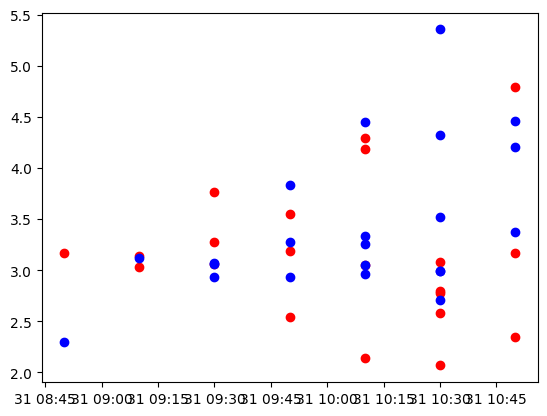

In [18]:
ax = plt.subplot()
for satellite_code in result_dict_1031_2:
    for i,height in enumerate(result_dict_1031_2[satellite_code]['maximal_height']):
        ax.scatter(result_dict_1031_2[satellite_code]['time'][i],height,c=[[1,0,0]])
for satellite_code in result_dict_1031_3:
    for i,height in enumerate(result_dict_1031_3[satellite_code]['maximal_height']):
        ax.scatter(result_dict_1031_3[satellite_code]['time'][i],height,c=[[0,0,1]])

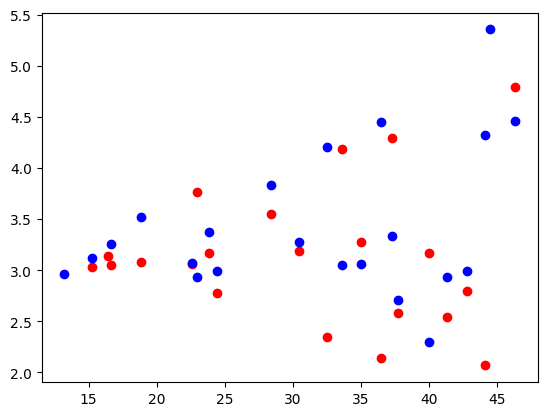

In [19]:
ax = plt.subplot()
for satellite_code in result_dict_1031_2:
    for i,height in enumerate(result_dict_1031_2[satellite_code]['maximal_height']):
        ax.scatter(result_dict_1031_2[satellite_code]['elevation'][i]['avg'],height,c=[[1,0,0]])
for satellite_code in result_dict_1031_3:
    for i,height in enumerate(result_dict_1031_3[satellite_code]['maximal_height']):
        ax.scatter(result_dict_1031_3[satellite_code]['elevation'][i]['avg'],height,c=[[0,0,1]])

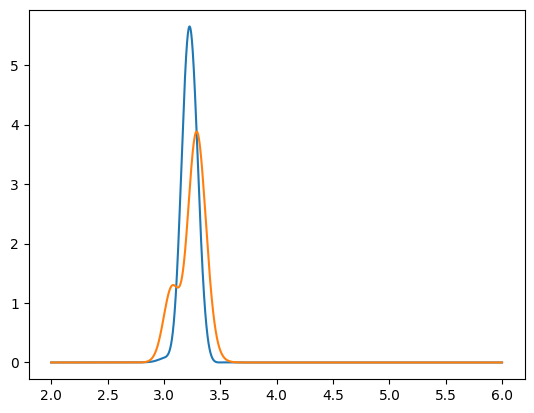

In [20]:
power_likelyhood_1031_2 = dapr.generate_power_likelihood(result_dict_1031_2)
power_likelyhood_1031_3 = dapr.generate_power_likelihood(result_dict_1031_3)
power_likelyhood_scaled_1031_2 = dapr.scale_power_to_unit_area(frequency,power_likelyhood_1031_2)
power_likelyhood_scaled_1031_3 = dapr.scale_power_to_unit_area(frequency,power_likelyhood_1031_3)
ax = plt.subplot()
ax.plot(frequency,power_likelyhood_scaled_1031_2)
ax.plot(frequency,power_likelyhood_scaled_1031_3)


In [27]:
main_path = os.path.abspath('../data/20221031/3/')

azimut_mask = [270,330]

min_height = 2
max_height = 6
frequency = dapr.generate_frequency(min_height=min_height,max_height=max_height)
starttime = datetime(year=2022,month=10,day=31,hour=8,minute=0,second=0,tzinfo=timezone.utc)
endtime = datetime(year=2022,month=10,day=31,hour=14,minute=0,second=0,tzinfo=timezone.utc)

ele_max_list = [25,30,35,40,45,50]
time_window_length_list = [5,10,15,20,25,30]

height_test_dict = {}
height_std_test_dict = {}
for ele_max in ele_max_list:
    height_test_dict[ele_max] = {}
    height_std_test_dict[ele_max] = {}
    for time_window_length in time_window_length_list:
        elevation_mask = [0, ele_max]
        deltatime = timedelta(minutes=time_window_length)

        data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,elevation_mask=elevation_mask,sn1_trigger=True)

        split_data_dict = dafi.split_data(data_dict,starttime,endtime,deltatime)
        result_dict = dapr.data_prepare(split_data_dict,frequency=frequency)
        result_dict_1031_3 = dapr.extract_height_as_max_peak(result_dict,frequency=frequency)
        height_all = []
        for satellite_code in result_dict_1031_3:
            for height in result_dict_1031_3[satellite_code]['maximal_height']:
                height_all.append(height)
        height_all = np.array(height_all)
        height_all = height_all[~np.isnan(height_all)]
        height_avg = np.average(height_all)
        height_std = np.std(height_all)
        height_test_dict[ele_max][time_window_length]=height_avg
        height_std_test_dict[ele_max][time_window_length]=height_std

In [63]:
def qual_check(height_test_dict,title):
    plt.figure(figsize=(7,7))
    plt.rcParams.update({'font.size': 22})
    v_temp = []
    x_temp = []
    y_temp = []
    for ele in height_test_dict:
        for t in height_test_dict[ele]:
            x_temp.append(ele)
            y_temp.append(t)
            v_temp.append(height_test_dict[ele][t])

    plt.scatter(x_temp,y_temp,c=v_temp,cmap='jet')
    plt.colorbar()
    plt.xlabel('max elevation range (grad)')
    plt.ylabel('time window lenghth (min)')
    plt.title(title)
    plt.title

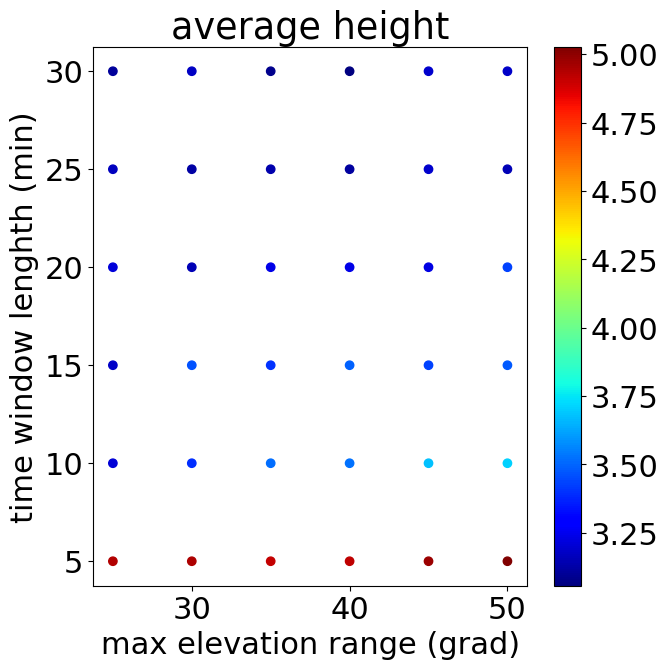

In [64]:
qual_check(height_test_dict,'average height')

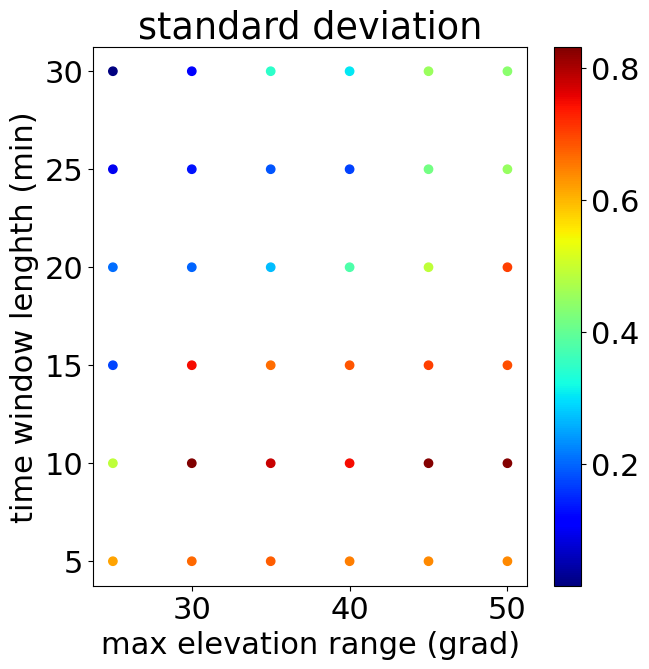

In [65]:
qual_check(height_std_test_dict,'standard deviation')